### 1-  getting datas by "GetData"
#### i have imported my datas from the DataBase from  seperate python file with the name "GetData"
#### and i have imported it into this file as you can see below

In [1]:
import GetData as d
import pandas as pd 
import matplotlib.pyplot as plt 
import scipy.stats as stats
import statsmodels.api as sm
from scipy.stats import shapiro
import numpy as np
from scipy.stats import zscore
import gender_guesser.detector as gender
import seaborn as sns



c:\Users\Parsa Pardaz\Desktop\Project\MusicStore\notebooks\GetData.py:24: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dataframes[table_name] = pd.read_sql(query, cnx)


done


### 2- analyzing tables by pandas and knowing some informations
#### knowing the datatypes 
#### if there is any null values 

In [10]:
def analyze_dataframe(df: pd.DataFrame, table_name: str):
    # Get the number of rows and columns
    num_rows, num_columns = df.shape
    
    # Get the number of null values in each column
    null_values = df.isnull().sum()
    data_types = df.dtypes
    
    # Build the result string
    result = f"Table {table_name} has {num_rows} rows and {num_columns} columns.\n"
    for column in df.columns:
        result += f'Column "{column}" has data type {data_types[column]} and {null_values[column]} null values.\n'
    
    # Print the result
    print(result)
    return result

In [11]:
analyze_dataframe(d.customer,'customer')
print("--------------------------------------------------")
analyze_dataframe(d.invoiceline,'invoiceline')
print("--------------------------------------------------")
analyze_dataframe(d.invoice,'invoice')
print("--------------------------------------------------")
analyze_dataframe(d.employee,'employee')
print("--------------------------------------------------")
analyze_dataframe(d.track,'track')
print("--------------------------------------------------")
analyze_dataframe(d.mediatype,'mediatype')
print("--------------------------------------------------")
analyze_dataframe(d.genre,'genre')
print("--------------------------------------------------")
analyze_dataframe(d.albums,'albums')
print("--------------------------------------------------")


Table customer has 59 rows and 13 columns.
Column "CustomerId" has data type int64 and 0 null values.
Column "FirstName" has data type object and 0 null values.
Column "LastName" has data type object and 0 null values.
Column "Company" has data type object and 49 null values.
Column "Address" has data type object and 0 null values.
Column "City" has data type object and 0 null values.
Column "State" has data type object and 29 null values.
Column "Country" has data type object and 0 null values.
Column "PostalCode" has data type object and 4 null values.
Column "Phone" has data type object and 1 null values.
Column "Fax" has data type object and 47 null values.
Column "Email" has data type object and 0 null values.
Column "SupportRepId" has data type int64 and 0 null values.

--------------------------------------------------
Table invoiceline has 2240 rows and 5 columns.
Column "InvoiceLineId" has data type int64 and 0 null values.
Column "InvoiceId" has data type int64 and 0 null val

In [12]:
# we have 1 null values in the employee table in the column "reportsTo" that seems to be very important
d.employee[d.employee['ReportsTo'].isnull()]
# no i fount out that he is a general manager now we have to see to who most of our general managers report 
d.employee[d.employee["Title"] =='General Manager']
# looks like Andrew is the only general manager we have and we do not know to whom he should report :/

,EmployeeId,LastName,FirstName,Title,ReportsTo,BirthDate,HireDate,Address,City,State,Country,PostalCode,Phone,Fax,Email
0,1,Adams,Andrew,General Manager,NaN,1962-02-18,2002-08-14,11120 Jasper Ave NW,Edmonton,AB,Canada,T5K 2N1,+1 (780) 428-9482,+1 (780) 428-3457,andrew@chinookcorp.com


#### there are some important things that we should consider 
##### the 5 countries that we had our most sale 
##### our top 5 genres 
##### what kind of music geners are most wanted in those 5 countries ???
 

,TotalRevenue
BillingCountry,
USA,523.06
Canada,303.96
France,195.10
Brazil,190.10
Germany,156.48


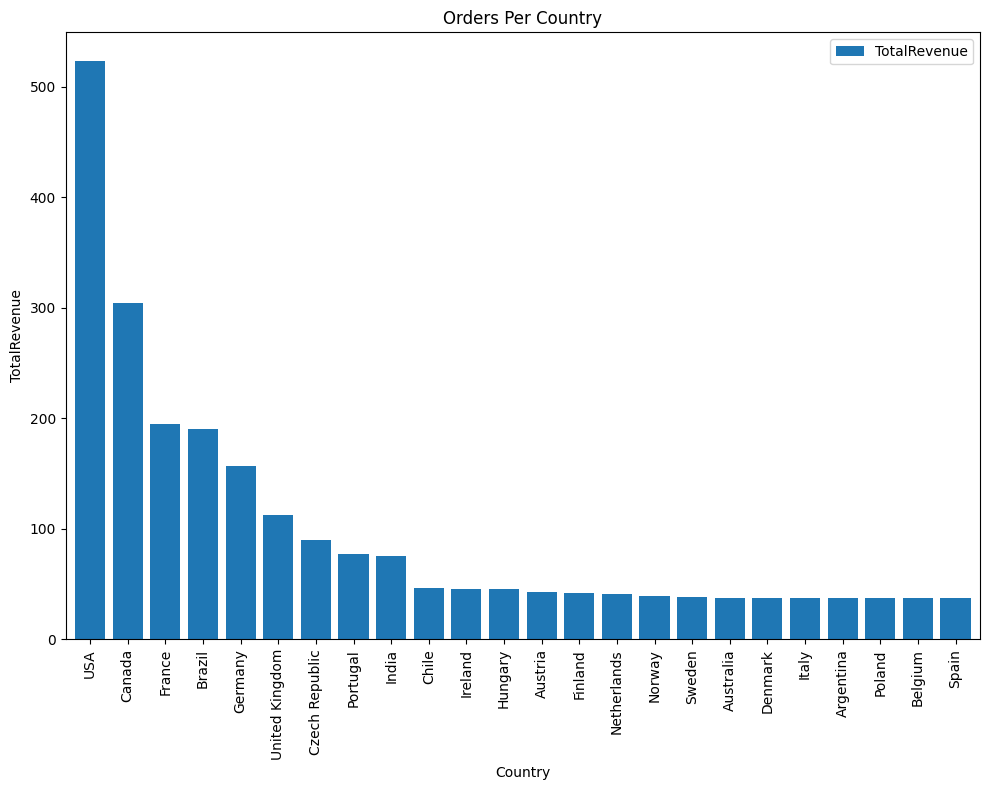

In [17]:
inv = d.invoice[['InvoiceId' , 'BillingCountry' , 'Total']]
invPerCountry = inv.groupby('BillingCountry').agg(TotalRevenue =('Total','sum')).sort_values('TotalRevenue', ascending=False)
display(invPerCountry.head(5))
# Plotting with matplotlib
ax = invPerCountry.plot(kind='bar', width=0.8, figsize=(10, 8)) 
plt.title('Orders Per Country')
plt.xlabel('Country')
plt.ylabel('TotalRevenue')
plt.xticks(rotation=90)
# Ensure the bars use the full width
plt.tight_layout()
plt.show()

invPerCountry = invPerCountry.reset_index()


In [18]:
# finding popular genres 




Track_genre =pd.merge(d.track[['TrackId' ,'GenreId']] , d.genre[['GenreId', 'Name']] , on='GenreId' )
Track_genre_invoiceline = pd.merge(Track_genre[['TrackId','Name']] , d.invoiceline[['TrackId','InvoiceLineId' , 'InvoiceId']] , on='TrackId')
Track_genre_invoiceline_invoice = pd.merge(Track_genre_invoiceline ,d.invoice[['InvoiceId', 'BillingCountry']] ,on='InvoiceId' )
FavTracksPerGenre =Track_genre_invoiceline.groupby('Name').agg(NumOfTracks_sold = ('InvoiceLineId','count')).sort_values(by='NumOfTracks_sold' ,ascending= False).head(5).reset_index()
FavTracksPerGenre

,Name,NumOfTracks_sold
0,Rock,835
1,Latin,386
2,Metal,264
3,Alternative & Punk,244
4,Jazz,80


# پرفروش ترین ژانر ها در پرفروشترین کشورها 

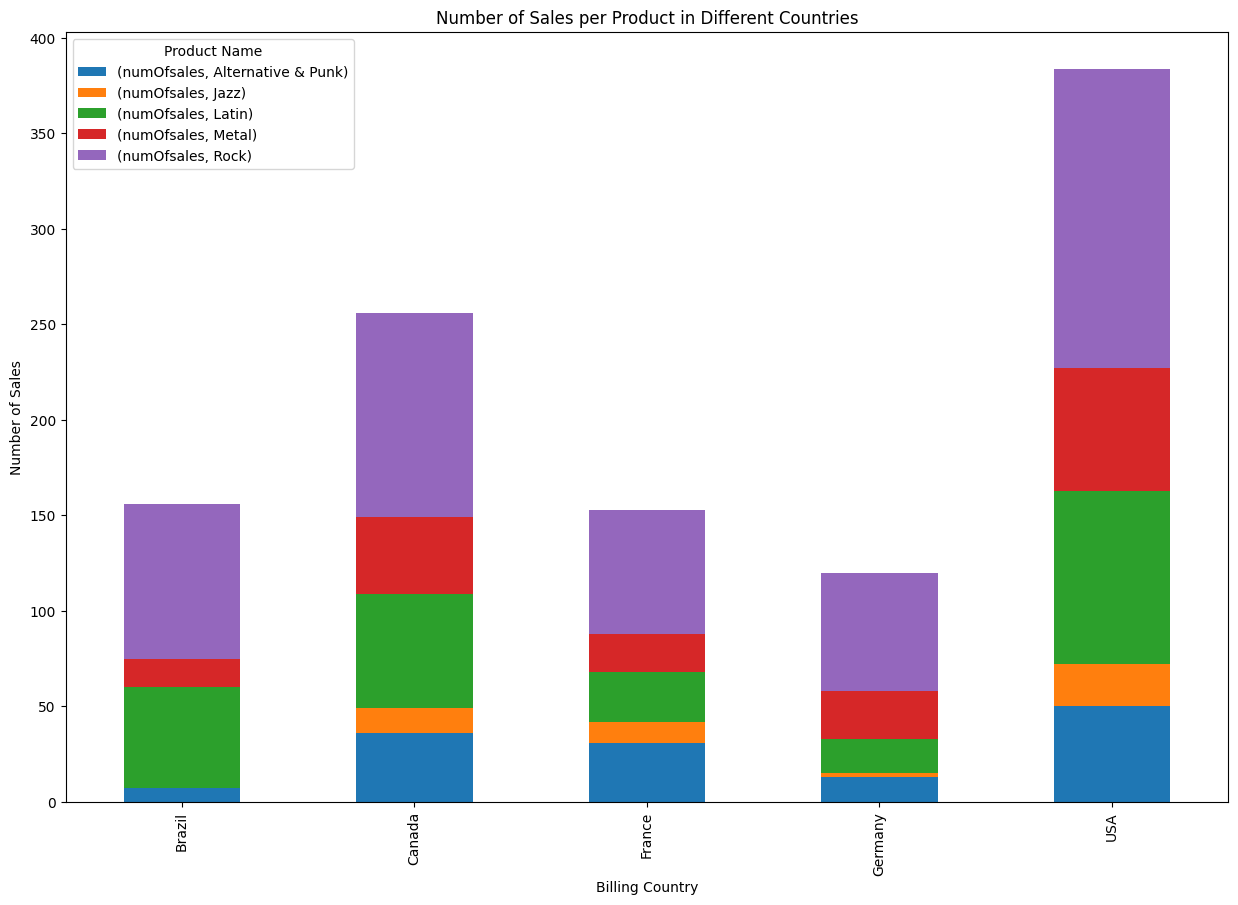

In [19]:
top5Countries = invPerCountry['BillingCountry'].head(5).tolist()
top5genres = FavTracksPerGenre['Name'].tolist()

top5s=Track_genre_invoiceline_invoice[Track_genre_invoiceline_invoice['BillingCountry'].isin(top5Countries) & Track_genre_invoiceline_invoice['Name'].isin(top5genres)]
top5sGrouped = top5s.groupby(['BillingCountry','Name']).agg(numOfsales = ('InvoiceLineId' , 'count')).unstack(fill_value=0).reset_index()


top5sGrouped.set_index('BillingCountry', inplace=True)
top5sGrouped.plot(kind='bar', stacked=True, figsize=(15, 10))
plt.title('Number of Sales per Product in Different Countries')
plt.xlabel('Billing Country')
plt.ylabel('Number of Sales')
plt.legend(title='Product Name')
plt.show()

## total revenue in each year 

In [20]:
ordrersPerYear = d.invoice[['Total','invoiceYear']]


groupedOrdersPerYear = ordrersPerYear.groupby('invoiceYear').agg(totalRevenue = ('Total' , 'sum')).sort_values(by='totalRevenue' ,ascending= False).reset_index()
groupedOrdersPerYear

,invoiceYear,totalRevenue
0,2022,481.45
1,2024,477.53
2,2023,469.58
3,2025,450.58
4,2021,449.46


## محبوبترین البوم ها در کشور های محبوبمون 

In [21]:
track_albums = pd.merge(d.albums , d.track[['AlbumId', 'TrackId']] , on='AlbumId')

In [22]:
track_albums_invoiceline = pd.merge(track_albums , d.invoiceline[['TrackId','InvoiceLineId','InvoiceId']] , on='TrackId')
track_albums_invoiceline

,AlbumId,Title,ArtistName,TrackId,InvoiceLineId,InvoiceId
0,1,For Those About To Rock We Salute You,AC/DC,1,579,108
1,1,For Those About To Rock We Salute You,AC/DC,6,3,2
2,1,For Those About To Rock We Salute You,AC/DC,8,4,2
3,1,For Those About To Rock We Salute You,AC/DC,8,1155,214
4,1,For Those About To Rock We Salute You,AC/DC,9,581,108
...,...,...,...,...,...,...
2235,338,Nielsen: The Six Symphonies,Göteborgs Symfoniker & Neeme Järvi,3494,1726,319
2236,340,Liszt - 12 Études D'Execution Transcendante,Michele Campanella,3496,577,108
2237,343,Respighi:Pines of Rome,Eugene Ormandy,3499,1153,214
2238,344,Schubert: The Late String Quartets & String Qu...,Emerson String Quartet,3500,578,108


In [23]:
track_albums_invoiceline_invoice = pd.merge(track_albums_invoiceline , d.invoice[['InvoiceId', 'BillingCountry']] , on='InvoiceId' )

track_albums_invoiceline_invoice
top5favCountries=track_albums_invoiceline_invoice[track_albums_invoiceline_invoice['BillingCountry'].isin(top5Countries)]
gropedtrack_albums_invoiceline_invoice = top5favCountries.groupby(['Title' ,'ArtistName','BillingCountry' ]).agg(NumOfTracks_Sold =('InvoiceLineId' , 'count')).sort_values(by='NumOfTracks_Sold' ,ascending= False).reset_index().drop_duplicates(subset='BillingCountry')
gropedtrack_albums_invoiceline_invoice

,Title,ArtistName,BillingCountry,NumOfTracks_Sold
0,"The Office, Season 3",The Office,USA,14
4,Arquivo II,Os Paralamas Do Sucesso,Canada,9
12,Use Your Illusion I,Guns N' Roses,Brazil,7
13,Minha Historia,Chico Buarque,France,7
27,Unplugged,Eric Clapton,Germany,5


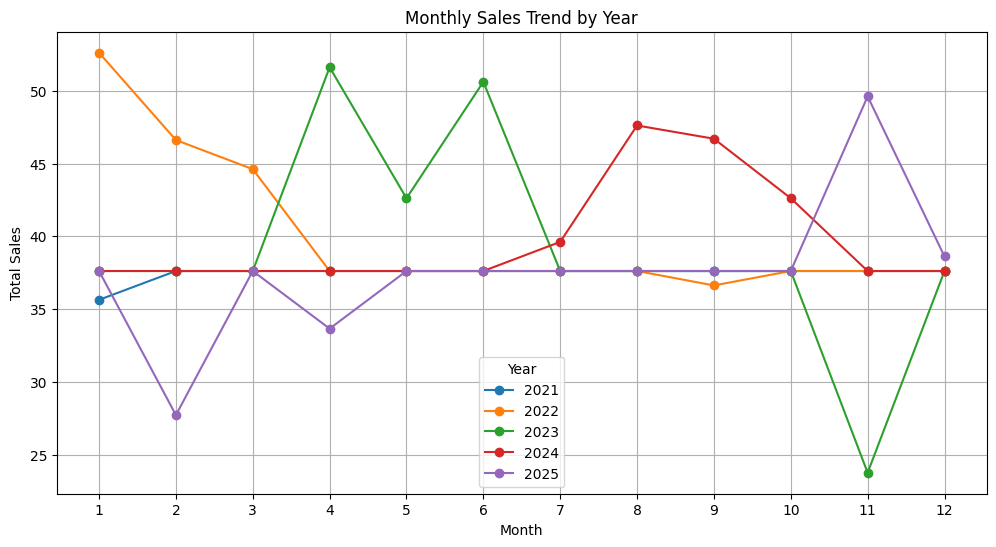

In [20]:
d.invoice['InvoiceDate'] = pd.to_datetime(d.invoice['InvoiceDate'])

# Extract year and month from InvoiceDate
d.invoice['Year'] = d.invoice['InvoiceDate'].dt.year
d.invoice['Month'] = d.invoice['InvoiceDate'].dt.month

# Group by Year and Month and sum the Total
monthly_sales = d.invoice.groupby(['Year', 'Month']).agg(totalRev = ('Total' , 'sum')).reset_index()

# Pivot the table to have months as columns and years as rows
pivot_table = monthly_sales.pivot(index='Month', columns='Year', values='totalRev')

# Plotting the data
plt.figure(figsize=(12, 6))
for year in pivot_table.columns:
    plt.plot(pivot_table.index, pivot_table[year], marker='o', label=str(year))

plt.title('Monthly Sales Trend by Year')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.legend(title='Year')
plt.xticks(range(1, 13))
plt.grid(True)
plt.show()

## see if our numerical values follow the normal desribution or not !?

#### we had 3 ways 1. visualizing with a histogram 2. Q-Q plot 3.shapiro wilk test 

In [21]:

d_invoice_total = d.invoice['Total']
d_track_milliseconds = d.track['Milliseconds']
d_track_bytes = d.track['Bytes']


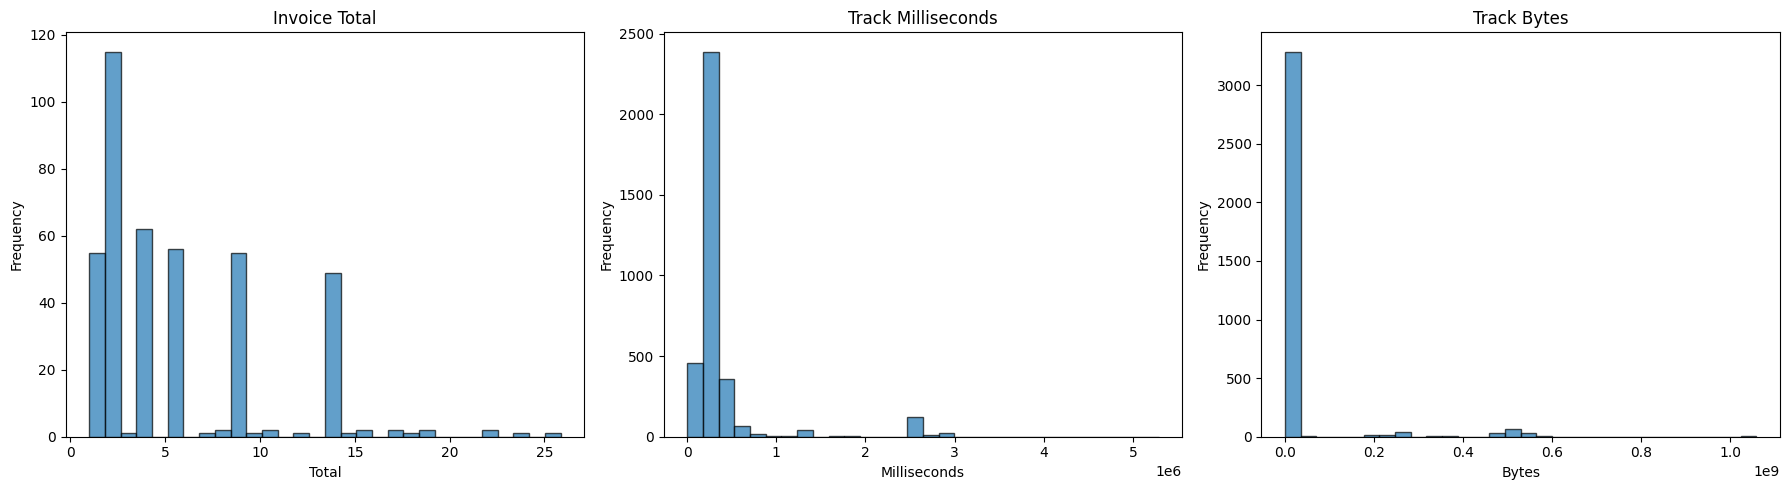

In [22]:
# Plot histograms
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.hist(d_invoice_total, bins=30, edgecolor='k', alpha=0.7)
plt.title('Invoice Total')
plt.xlabel('Total')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.hist(d_track_milliseconds, bins=30, edgecolor='k', alpha=0.7)
plt.title('Track Milliseconds')
plt.xlabel('Milliseconds')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
plt.hist(d_track_bytes, bins=30, edgecolor='k', alpha=0.7)
plt.title('Track Bytes')
plt.xlabel('Bytes')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


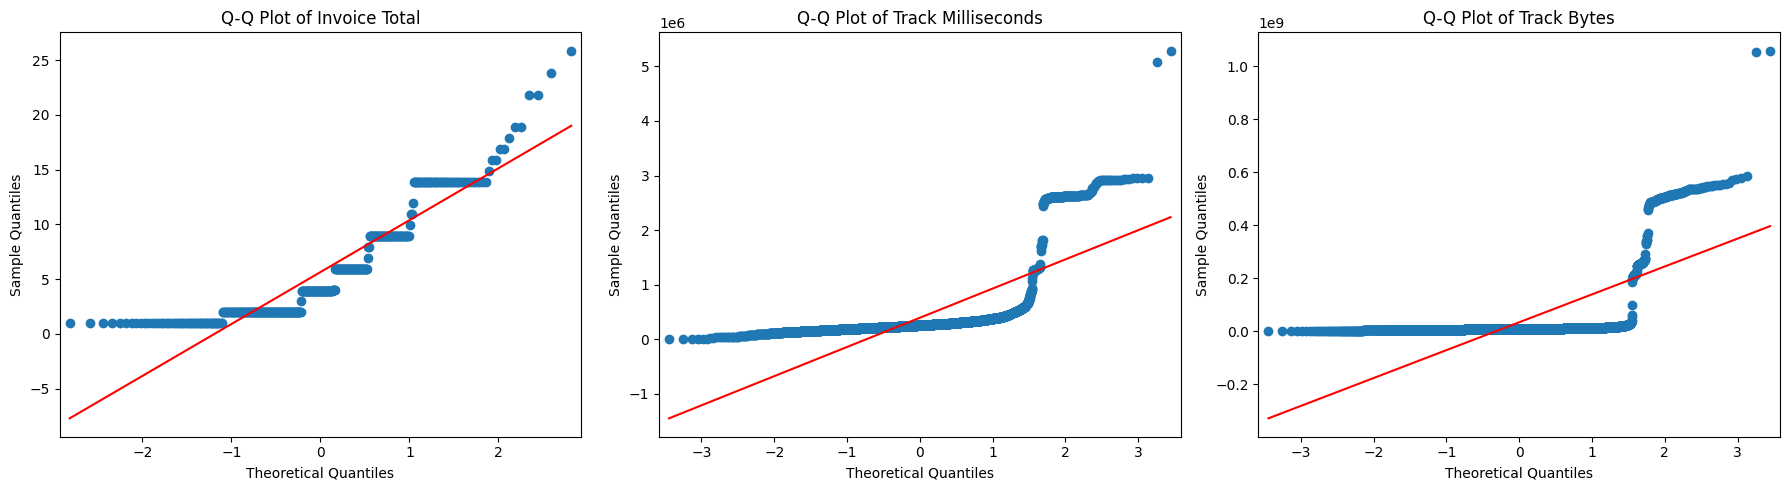

In [23]:
# Plotting Q-Q plots side by side in a single figure
plt.figure(figsize=(18, 5))

# Q-Q plot for Invoice Total
plt.subplot(1, 3, 1)
sm.qqplot(d_invoice_total, line='s', ax=plt.gca())
plt.title('Q-Q Plot of Invoice Total')

# Q-Q plot for Track Milliseconds
plt.subplot(1, 3, 2)
sm.qqplot(d_track_milliseconds, line='s', ax=plt.gca())
plt.title('Q-Q Plot of Track Milliseconds')

# Q-Q plot for Track Bytes
plt.subplot(1, 3, 3)
sm.qqplot(d_track_bytes, line='s', ax=plt.gca())
plt.title('Q-Q Plot of Track Bytes')

plt.tight_layout()
plt.show()

In [24]:

# Define the alpha level
alpha = 0.05

# Perform the Shapiro-Wilk test
shapiro_results = {
    'Invoice Total': shapiro(d_invoice_total),
    'Track Milliseconds': shapiro(d_track_milliseconds),
    'Track Bytes': shapiro(d_track_bytes)
}

# Print the results
for key, value in shapiro_results.items():
    W, p_value = value
    if p_value > alpha:
        print(f"{key}: p-value={p_value:.4f} > {alpha} (Fail to reject the null hypothesis - data is likely normal)")
    else:
        print(f"{key}: p-value={p_value:.4f} <= {alpha} (Reject the null hypothesis - data is not normal)")

Invoice Total: p-value=0.0000 <= 0.05 (Reject the null hypothesis - data is not normal)
Track Milliseconds: p-value=0.0000 <= 0.05 (Reject the null hypothesis - data is not normal)
Track Bytes: p-value=0.0000 <= 0.05 (Reject the null hypothesis - data is not normal)


# how to find the outlier datas and what to do with them ??

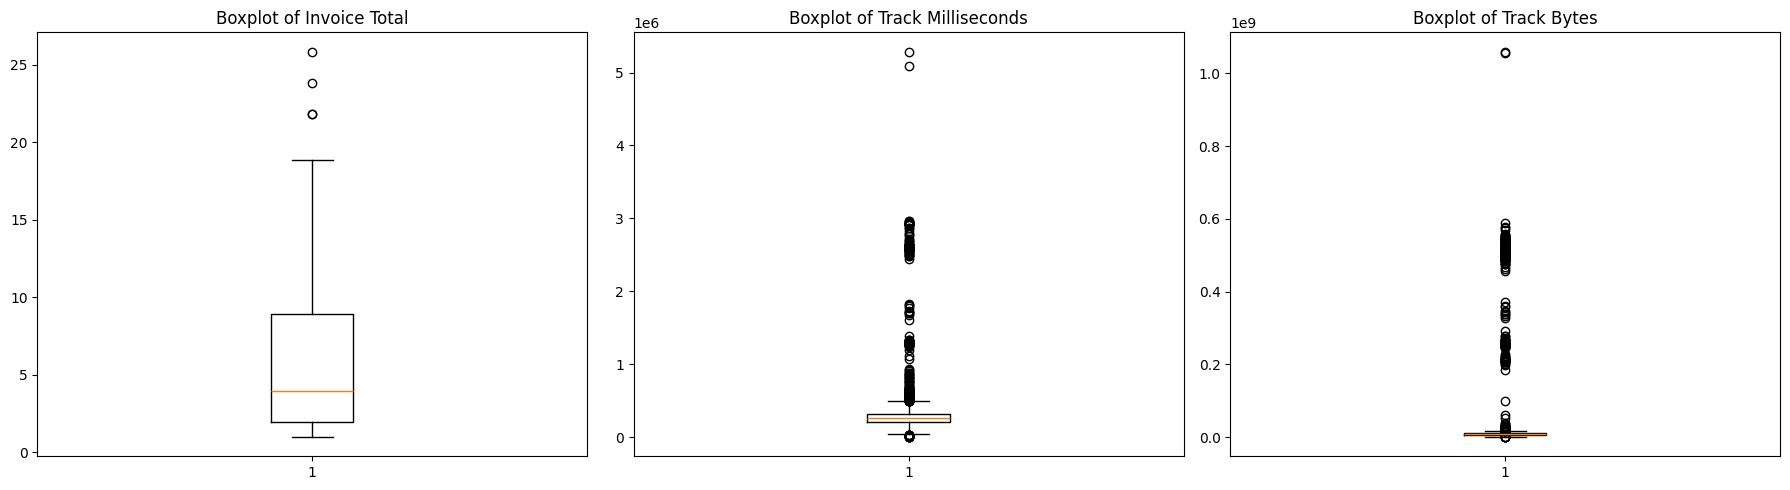

In [25]:
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.boxplot(d_invoice_total)
plt.title('Boxplot of Invoice Total')

plt.subplot(1, 3, 2)
plt.boxplot(d_track_milliseconds)
plt.title('Boxplot of Track Milliseconds')

plt.subplot(1, 3, 3)
plt.boxplot(d_track_bytes)
plt.title('Boxplot of Track Bytes')

plt.tight_layout()
plt.show()

In [26]:
z_scores_invoice_total = zscore(d_invoice_total)
z_scores_track_milliseconds = zscore(d_track_milliseconds)
z_scores_track_bytes = zscore(d_track_bytes)

# Identify outliers (Z-Score > 3 or < -3)
outliers_invoice_total = np.where(np.abs(z_scores_invoice_total) > 3)
outliers_track_milliseconds = np.where(np.abs(z_scores_track_milliseconds) > 3)
outliers_track_bytes = np.where(np.abs(z_scores_track_bytes) > 3)

print("Outliers in Invoice Total:", outliers_invoice_total)
print("Outliers in Track Milliseconds:", outliers_track_milliseconds)
print("Outliers in Track Bytes:", outliers_track_bytes)

Outliers in Invoice Total: (array([ 95, 193, 298, 403]),)
Outliers in Track Milliseconds: (array([2818, 2819, 2820, 2821, 2822, 2823, 2824, 2825, 2826, 2827, 2828,
       2829, 2830, 2831, 2832, 2833, 2834, 2835, 2836, 2837, 2838, 2839,
       2840, 2841, 2842, 2843, 2844, 2845, 2846, 2847, 2848, 2849, 2850,
       2851, 2852, 2853, 2854, 2855, 2856, 2857, 2858, 2859, 2860, 2861,
       2862, 2863, 2864, 2865, 2866, 2867, 2868, 2869, 2870, 2871, 2872,
       2873, 2874, 2875, 2876, 2877, 2878, 2879, 2880, 2881, 2882, 2883,
       2884, 2885, 2886, 2887, 2888, 2889, 2890, 2891, 2892, 2893, 2894,
       2895, 2896, 2897, 2898, 2899, 2900, 2901, 2902, 2903, 2904, 2905,
       2906, 2907, 2908, 2909, 2910, 2911, 2912, 2913, 2914, 2915, 2916,
       2917, 2918, 2919, 2920, 2921, 2922, 2923, 2924, 3164, 3165, 3166,
       3167, 3168, 3169, 3170, 3208, 3221, 3222, 3223, 3225, 3226, 3227,
       3228, 3229, 3230, 3231, 3232, 3233, 3234, 3235, 3236, 3237, 3238,
       3239, 3240, 3241, 3242, 32

In [27]:
top3genres = FavTracksPerGenre['Name'].head(3).tolist()


In [36]:
Track_genre_withPrice =pd.merge(d.track[['GenreId' , 'UnitPrice']] , d.genre[['GenreId', 'Name']] , on='GenreId' )
Track_genre_withPrice = Track_genre_withPrice[Track_genre_withPrice['Name'].isin(top3genres)]
# Separate the data into different genres
genre1_prices = Track_genre_withPrice[Track_genre_withPrice['Name'] == top3genres[0]]['UnitPrice']
genre2_prices = Track_genre_withPrice[Track_genre_withPrice['Name'] == top3genres[1]]['UnitPrice']
genre3_prices = Track_genre_withPrice[Track_genre_withPrice['Name'] == top3genres[2]]['UnitPrice']

# Step 4: Conduct Kruskal-Wallis H-test
kruskal_result = stats.kruskal(genre1_prices ,genre2_prices , genre3_prices)

# Step 5: Display the result
alpha = 0.05
print('Kruskal-Wallis test result:', kruskal_result)
print(f"H-statistic: {kruskal_result.statistic}, p-value: {kruskal_result.pvalue}")

# Step 6: Hypothesis testing
if kruskal_result.pvalue < alpha:
    print("H0 hypothesis is rejected: There is a significant difference in the distributions of the prices between the three genres.")
else:
    print("H0 hypothesis is not rejected: There is no significant difference in the distributions of the prices between the three genres.")


ValueError: All numbers are identical in kruskal

## the func for calculating the correlation 

In [13]:
def check_independence(column1, column2):
    # Perform Shapiro-Wilk test to check for normality
    normality_col1 = stats.shapiro(column1)
    normality_col2 = stats.shapiro(column2)
    
    print('Shapiro-Wilk test for normality of first column:', normality_col1)
    print('Shapiro-Wilk test for normality of second column:', normality_col2)
    
    # Set significance level
    alpha = 0.05
    
    # Pearson correlation (for normally distributed data)
    if normality_col1.pvalue > alpha and normality_col2.pvalue > alpha:
        pearson_corr, pearson_p_value = stats.pearsonr(column1, column2)
        print("Using Pearson correlation")
        print(f'Pearson correlation coefficient: {pearson_corr}, p-value: {pearson_p_value}')
        
        if pearson_p_value < alpha:
            print("H0 hypothesis is rejected for Pearson: There is a significant relationship between the two columns.")
        else:
            print("H0 hypothesis is not rejected for Pearson: There is no significant relationship between the two columns.")
    else:
        print("Data is not normally distributed; skipping Pearson correlation.")
    
    # Spearman's rank correlation (for non-parametric data)
    spearman_corr, spearman_p_value = stats.spearmanr(column1, column2)
    print("Using Spearman's rank correlation")
    print(f'Spearman correlation coefficient: {spearman_corr}, p-value: {spearman_p_value}')
    
    if spearman_p_value < alpha:
        print("H0 hypothesis is rejected for Spearman: There is a significant relationship between the two columns.")
    else:
        print("H0 hypothesis is not rejected for Spearman: There is no significant relationship between the two columns.")
    
    # Kendall's Tau correlation (for non-parametric data)
    kendall_corr, kendall_p_value = stats.kendalltau(column1, column2)
    print("Using Kendall's Tau correlation")
    print(f'Kendall Tau correlation coefficient: {kendall_corr}, p-value: {kendall_p_value}')
    
    if kendall_p_value < alpha:
        print("H0 hypothesis is rejected for Kendall: There is a significant relationship between the two columns.")
    else:
        print("H0 hypothesis is not rejected for Kendall: There is no significant relationship between the two columns.")



# q 7 part2

In [39]:
track_df = d.track.copy()
track_df['Seconds'] = track_df['Milliseconds'] / 1000


check_independence(track_df['Seconds'], track_df['UnitPrice'])


Shapiro-Wilk test for normality of first column: ShapiroResult(statistic=np.float64(0.40693509805829453), pvalue=np.float64(2.7287436202313686e-75))
Shapiro-Wilk test for normality of second column: ShapiroResult(statistic=np.float64(0.25366636273367993), pvalue=np.float64(3.981126478782177e-80))
Data is not normally distributed; skipping Pearson correlation.
Using Spearman's rank correlation
Spearman correlation coefficient: 0.4099206080846446, p-value: 4.576036687486155e-142
H0 hypothesis is rejected for Spearman: There is a significant relationship between the two columns.
Using Kendall's Tau correlation
Kendall Tau correlation coefficient: 0.3347592493756593, p-value: 5.423313763021763e-130
H0 hypothesis is rejected for Kendall: There is a significant relationship between the two columns.


In [41]:
customer_invoice = pd.merge(d.customer[['CustomerId', 'FirstName']] , d.invoice[['CustomerId' , 'Total']] , on='CustomerId')


,CustomerId,FirstName,Total
0,1,Luís,3.98
1,1,Luís,3.96
2,1,Luís,5.94
3,1,Luís,0.99
4,1,Luís,1.98
...,...,...,...
407,59,Puja,5.94
408,59,Puja,1.99
409,59,Puja,1.98
410,59,Puja,13.86


In [44]:

# Initialize the gender detector
d = gender.Detector()

# Function to infer gender
def get_gender(first_name):
    guess = d.get_gender(first_name)
    if guess in ['male', 'mostly_male']:
        return 'Male'
    elif guess in ['female', 'mostly_female']:
        return 'Female'
    else:
        return 'Unknown'

# Apply the function to the 'FirstName' column
customer_invoice['Gender'] = customer_invoice['FirstName'].apply(get_gender)

grouped_customer_invoice = customer_invoice.groupby('Gender').agg(totalSpend = ('Total' , 'sum'))
grouped_customer_invoice


,totalSpend
Gender,
Female,711.16
Male,1498.56
Unknown,118.88


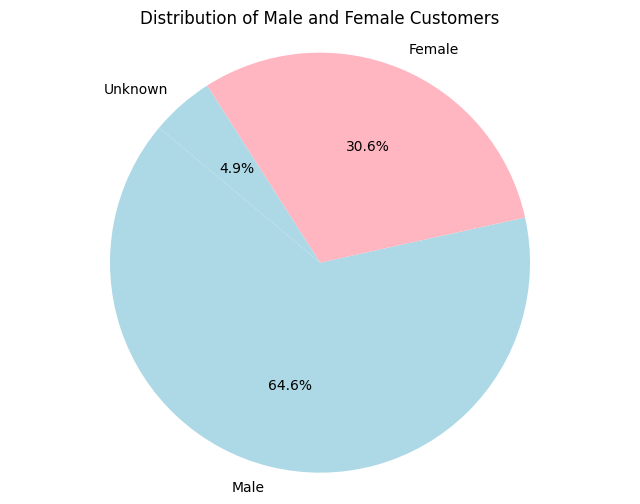

In [45]:
gender_counts = customer_invoice['Gender'].value_counts()

# Plotting the pie chart
plt.figure(figsize=(8, 6))
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=140, colors=['lightblue', 'lightpink'])
plt.title('Distribution of Male and Female Customers')
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
plt.show()

In [55]:
check_independence(d.track['GenreId'] , d.track['MediaTypeId'])

Shapiro-Wilk test for normality of first column: ShapiroResult(statistic=np.float64(0.7534053877646015), pvalue=np.float64(3.0362706126633494e-58))
Shapiro-Wilk test for normality of second column: ShapiroResult(statistic=np.float64(0.4039879990189643), pvalue=np.float64(2.1542845589793834e-75))
Data is not normally distributed; skipping Pearson correlation.
Using Spearman's rank correlation
Spearman correlation coefficient: 0.42531359866022905, p-value: 6.376408759031223e-154
H0 hypothesis is rejected for Spearman: There is a significant relationship between the two columns.
Using Kendall's Tau correlation
Kendall Tau correlation coefficient: 0.3603853288743987, p-value: 3.8140749856974296e-134
H0 hypothesis is rejected for Kendall: There is a significant relationship between the two columns.


# q7 extra


In [28]:
# the correlation between the tracks prices and the bytes 
check_independence (d.track['UnitPrice'] , d.track['Bytes'])

Shapiro-Wilk test for normality of first column: ShapiroResult(statistic=np.float64(0.25366636273367993), pvalue=np.float64(3.981126478782177e-80))
Shapiro-Wilk test for normality of second column: ShapiroResult(statistic=np.float64(0.2756405817618164), pvalue=np.float64(1.7275565060666367e-79))
Data is not normally distributed; skipping Pearson correlation.
Using Spearman's rank correlation
Spearman correlation coefficient: 0.41386143347943216, p-value: 4.831360302670962e-145
H0 hypothesis is rejected for Spearman: There is a significant relationship between the two columns.
Using Kendall's Tau correlation
Kendall Tau correlation coefficient: 0.3379647294599055, p-value: 1.825635188273088e-132
H0 hypothesis is rejected for Kendall: There is a significant relationship between the two columns.


In [27]:
# the correaltion between the count of the customers in each year with total revenue 

groped =d.invoice.groupby('invoiceYear').agg(countOfCustomers = ('CustomerId' , 'count') , totalRevenue = ('Total' , 'sum')).reset_index()
check_independence(groped['countOfCustomers'], groped['totalRevenue'])

Shapiro-Wilk test for normality of first column: ShapiroResult(statistic=np.float64(0.5521816835012407), pvalue=np.float64(0.00013097817774592886))
Shapiro-Wilk test for normality of second column: ShapiroResult(statistic=np.float64(0.8610261515192984), pvalue=np.float64(0.23195609494530167))
Data is not normally distributed; skipping Pearson correlation.
Using Spearman's rank correlation
Spearman correlation coefficient: 0.35355339059327373, p-value: 0.5594043441634878
H0 hypothesis is not rejected for Spearman: There is no significant relationship between the two columns.
Using Kendall's Tau correlation
Kendall Tau correlation coefficient: 0.31622776601683794, p-value: 0.4795001221869535
H0 hypothesis is not rejected for Kendall: There is no significant relationship between the two columns.


In [26]:
groupedCountriesWithCities = d.invoice.groupby('BillingCountry').agg(countOfCities = ('BillingCity' , 'count') , TotalRev = ('Total' , 'sum')).sort_values(by='TotalRev' ,ascending= False).reset_index()
display(groupedCountriesWithCities)
check_independence(groupedCountriesWithCities['countOfCities'], groupedCountriesWithCities['TotalRev'])


,BillingCountry,countOfCities,TotalRev
0,USA,91,523.06
1,Canada,56,303.96
2,France,35,195.10
3,Brazil,35,190.10
4,Germany,28,156.48
5,United Kingdom,21,112.86
6,Czech Republic,14,90.24
7,Portugal,14,77.24
8,India,13,75.26
9,Chile,7,46.62


Shapiro-Wilk test for normality of first column: ShapiroResult(statistic=np.float64(0.587955933171975), pvalue=np.float64(4.5456475562820406e-07))
Shapiro-Wilk test for normality of second column: ShapiroResult(statistic=np.float64(0.5961482517177052), pvalue=np.float64(5.596746323173867e-07))
Data is not normally distributed; skipping Pearson correlation.
Using Spearman's rank correlation
Spearman correlation coefficient: 0.8721311205696557, p-value: 2.817029901067659e-08
H0 hypothesis is rejected for Spearman: There is a significant relationship between the two columns.
Using Kendall's Tau correlation
Kendall Tau correlation coefficient: 0.7970811413304556, p-value: 1.1395549431145288e-06
H0 hypothesis is rejected for Kendall: There is a significant relationship between the two columns.


# Q8

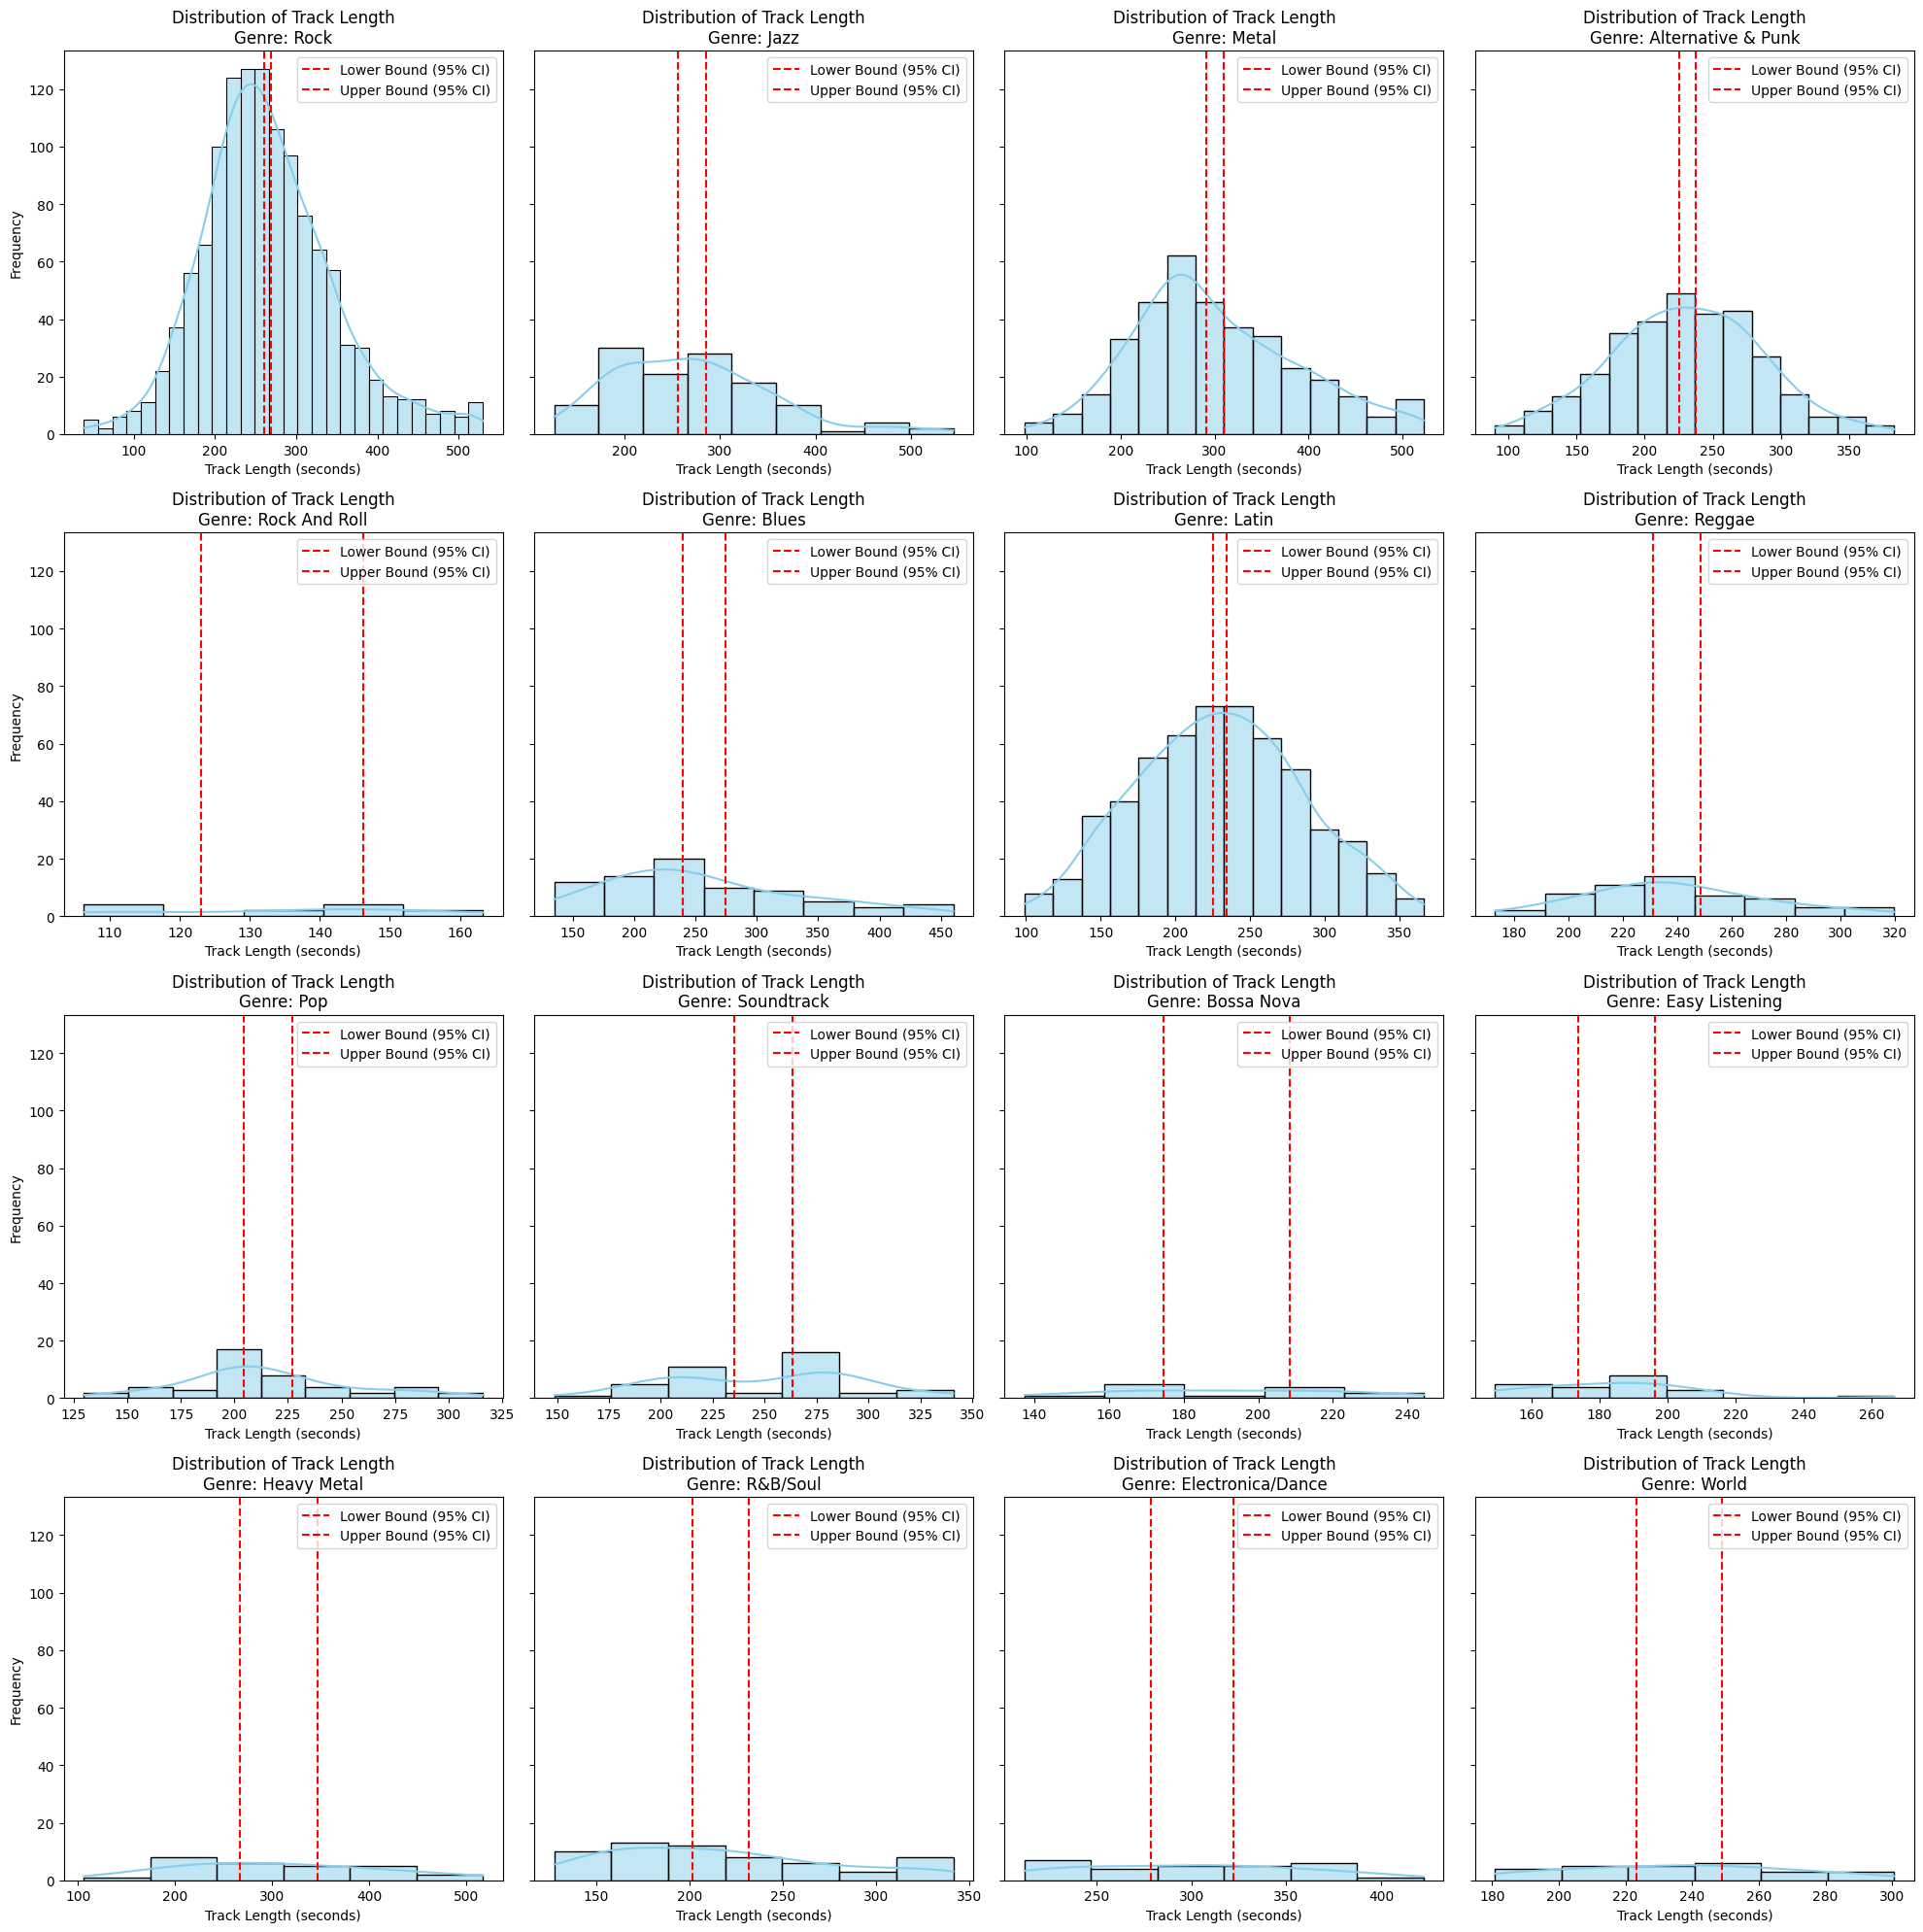

                 Genre        Mean  CI Lower Bound  CI Upper Bound
0                 Rock  264.910116      260.414826      269.405407
1                 Jazz  270.677435      256.025981      285.328890
2                Metal  300.311913      291.350071      309.273754
3   Alternative & Punk  231.184638      225.131782      237.237493
4        Rock And Roll  134.643500      123.056923      146.230077
5                Blues  257.175039      239.524336      274.825742
6                Latin  230.105940      225.542897      234.668983
7               Reggae  239.627481      230.841253      248.413710
8                  Pop  215.658804      204.228838      227.088770
9           Soundtrack  249.277025      235.117544      263.436506
10          Bossa Nova  191.649846      174.781511      208.518181
11      Easy Listening  184.869381      173.607923      196.130839
12         Heavy Metal  306.691444      266.915878      346.467011
13            R&B/Soul  216.763083      201.744263      231.78

In [52]:
Track_genre2 = pd.merge(d.track[['GenreId' , 'TrackId' , 'Milliseconds']] , d.genre[['GenreId' , 'Name']] , on='GenreId')
Track_genre2['Seconds'] = Track_genre2['Milliseconds'] / 1000
Track_genre2Grouped  = Track_genre2.groupby('Name').agg(mean = ('Seconds' , 'mean')).reset_index()

# Calculate the z-score for each track length within each genre
Track_genre2['zscore'] = Track_genre2.groupby('Name')['Seconds'].transform(lambda x: np.abs(stats.zscore(x)))

# Define the threshold for considering a point as an outlier
threshold = 2

# Filter out the outliers
Track_genre2_no_outliers = Track_genre2[Track_genre2['zscore'] < threshold].drop(columns=['zscore'])

confidence_level = 0.95
z = stats.norm.ppf(1 - (1 - confidence_level) / 2)  # critical value for 95% confidence

results = []

# Number of genres
num_genres = Track_genre2_no_outliers['Name'].nunique()
rows = 4
cols = 4
total_plots = min(rows * cols, num_genres)  # Total number of plots

# Create a figure with a 4x4 grid of subplots
fig, axes = plt.subplots(rows, cols, figsize=(20, 20), sharey=True)
axes = axes.flatten()  # Flatten the 2D array of axes for easier iteration

# Iterate over each genre and create a subplot
for ax, genre in zip(axes, Track_genre2_no_outliers['Name'].unique()):
    genre_data = Track_genre2_no_outliers[Track_genre2_no_outliers['Name'] == genre]['Seconds']
    
    sample_mean = np.mean(genre_data)
    sample_std = np.std(genre_data, ddof=1)  # sample standard deviation
    n = len(genre_data)
    
    standard_error = sample_std / np.sqrt(n)
    
    lower_bound = sample_mean - z * standard_error
    upper_bound = sample_mean + z * standard_error
    
    results.append({
        'Genre': genre,
        'Mean': sample_mean,
        'CI Lower Bound': lower_bound,
        'CI Upper Bound': upper_bound
    })
    
    # Plotting histogram with confidence interval
    sns.histplot(genre_data, kde=True, color='skyblue', ax=ax)
    ax.axvline(x=lower_bound, color='red', linestyle='--', label='Lower Bound (95% CI)')
    ax.axvline(x=upper_bound, color='red', linestyle='--', label='Upper Bound (95% CI)')
    ax.set_title(f'Distribution of Track Length\nGenre: {genre}')
    ax.set_xlabel('Track Length (seconds)')
    ax.set_ylabel('Frequency')
    ax.legend()

# Remove empty subplots if any
for i in range(total_plots, rows * cols):
    fig.delaxes(axes[i])

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

# Create a DataFrame to display the results
confidence_intervals = pd.DataFrame(results)
print(confidence_intervals)

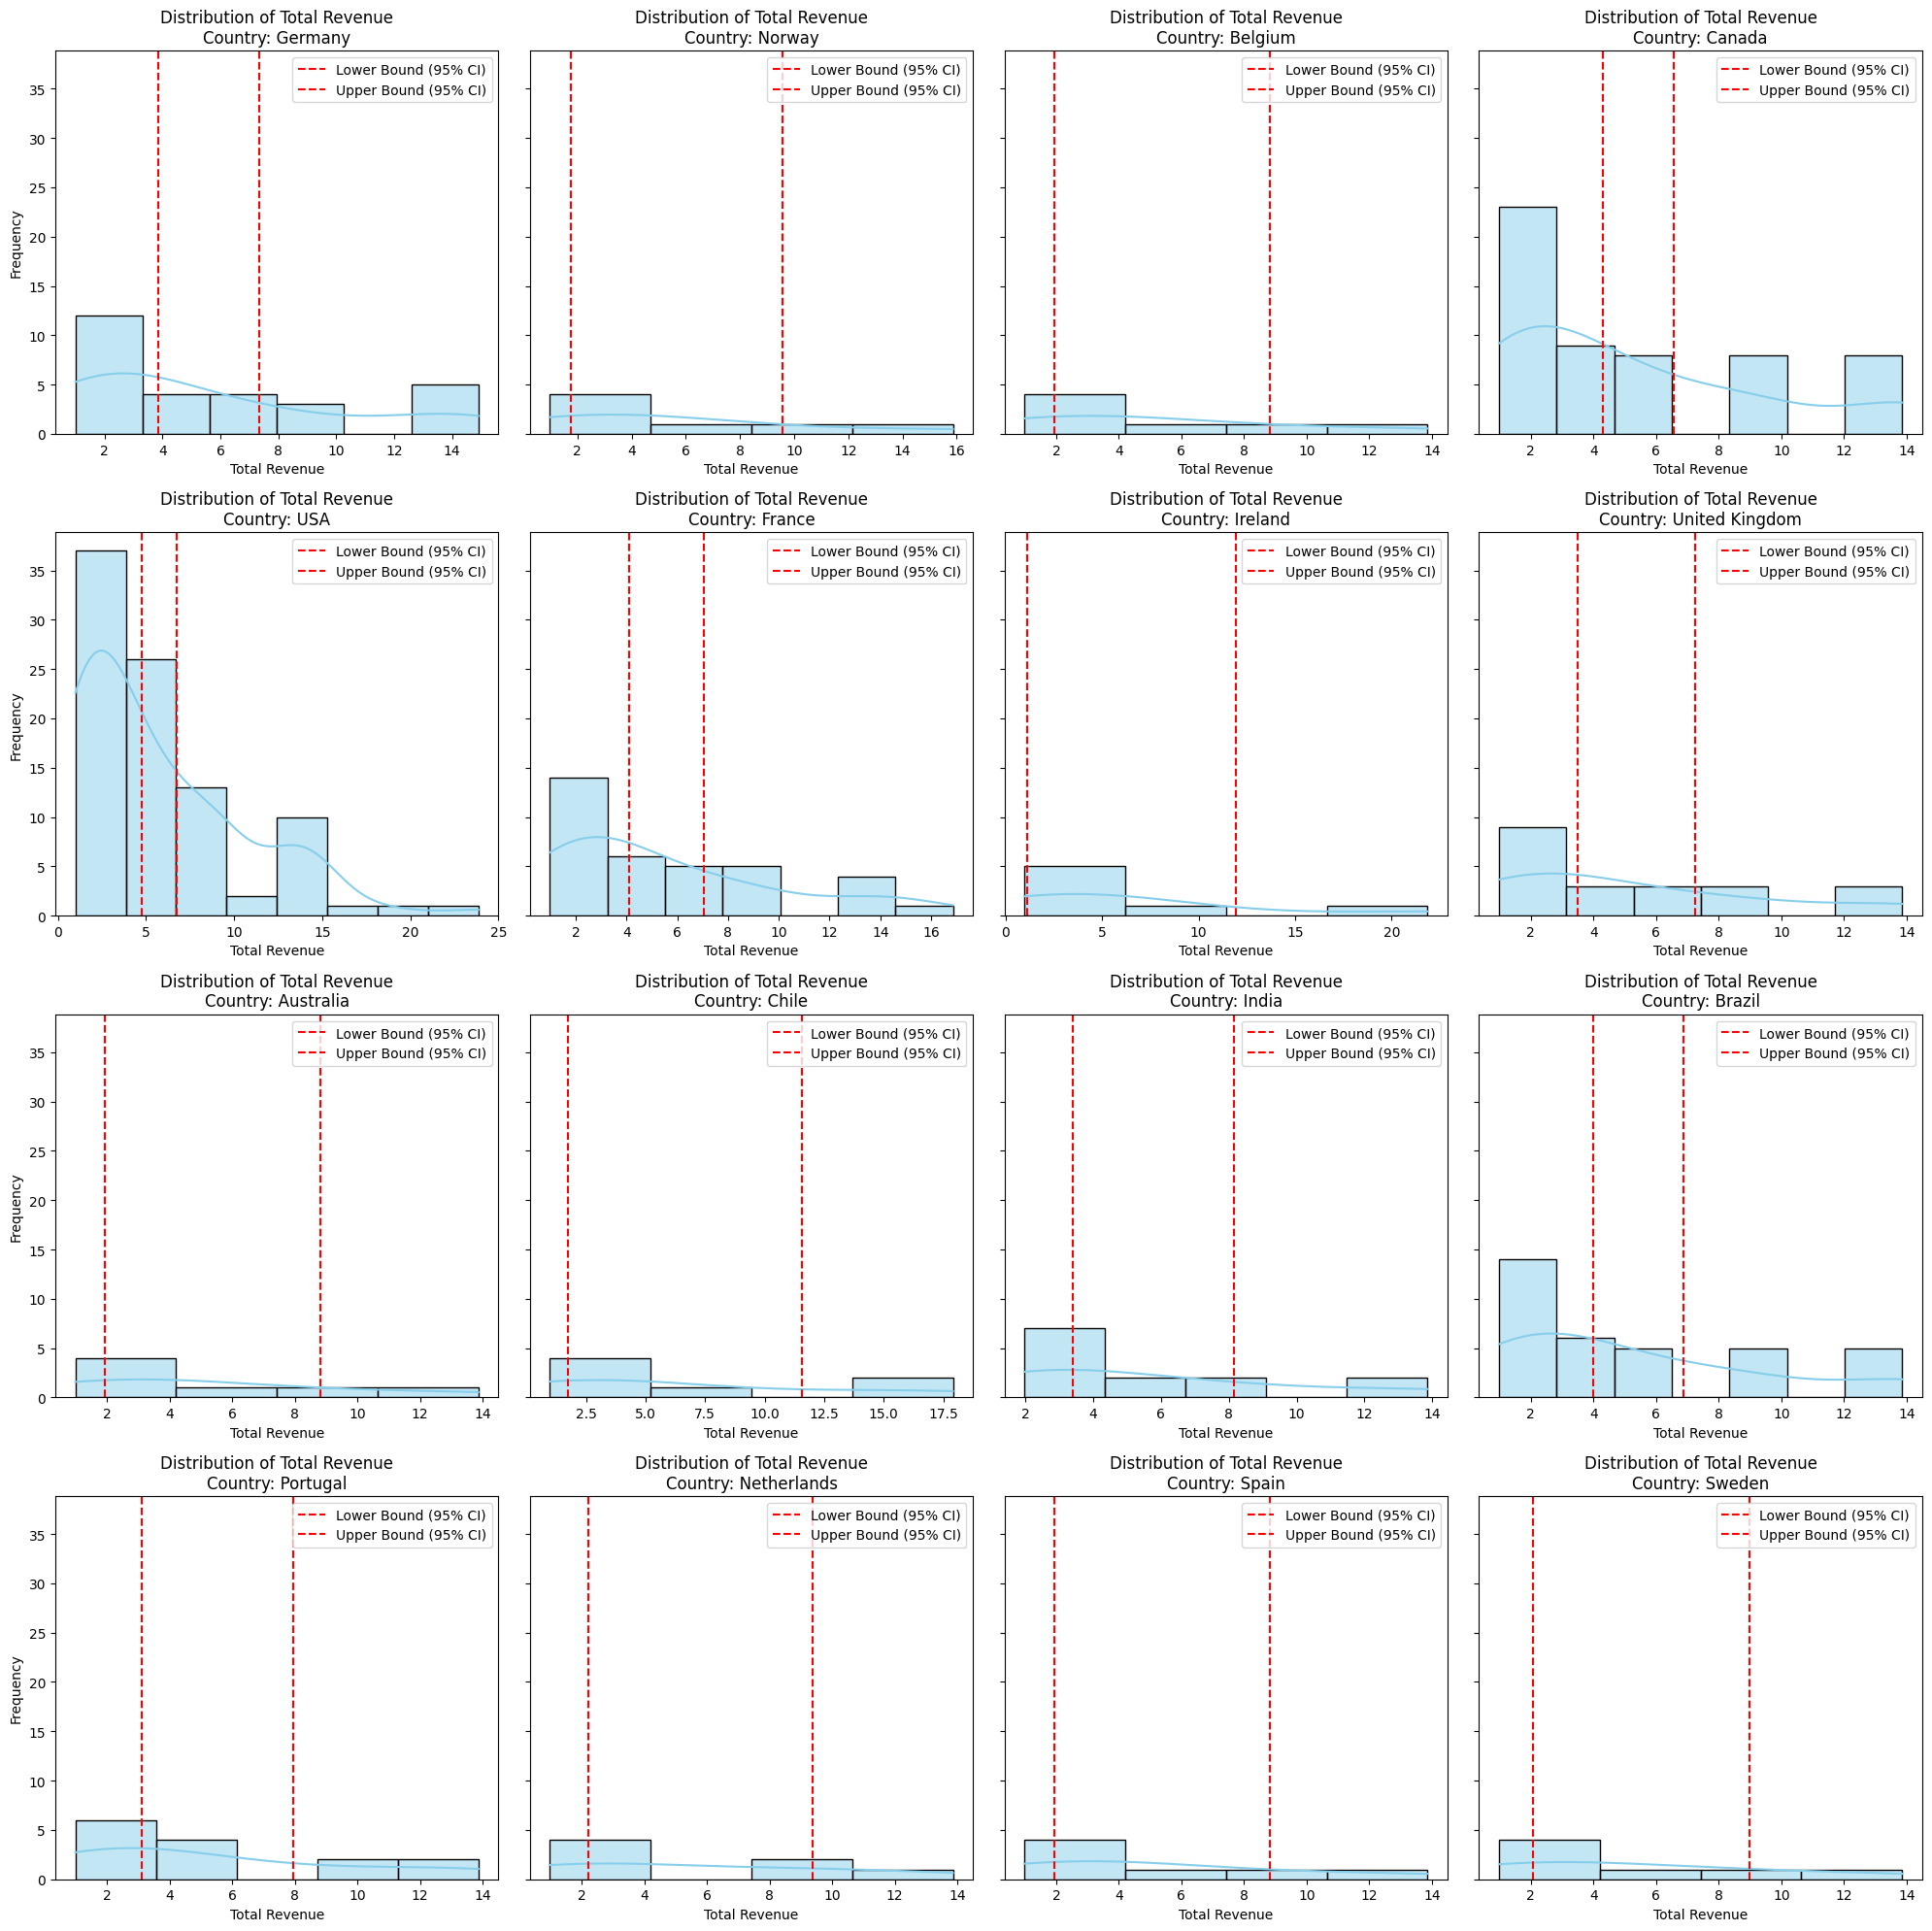

           Country      Mean  CI Lower Bound  CI Upper Bound
0          Germany  5.588571        3.851958        7.325185
1           Norway  5.660000        1.758026        9.561974
2          Belgium  5.374286        1.938112        8.810459
3           Canada  5.427857        4.293842        6.561872
4              USA  5.747912        4.750327        6.745497
5           France  5.574286        4.091771        7.056800
6          Ireland  6.517143        1.109481       11.924805
7   United Kingdom  5.374286        3.492216        7.256355
8        Australia  5.374286        1.938112        8.810459
9            Chile  6.660000        1.763221       11.556779
10           India  5.789231        3.415131        8.163330
11          Brazil  5.431429        3.998825        6.864033
12        Portugal  5.517143        3.103344        7.930942
13     Netherlands  5.802857        2.221892        9.383823
14           Spain  5.374286        1.938112        8.810459
15          Sweden  5.51

In [53]:
inv = d.invoice[['InvoiceId' , 'BillingCountry' , 'Total']]
invPerCountry = inv.groupby('BillingCountry').agg(meanOfRevenue=('Total', 'mean')).reset_index()

confidence_level = 0.95
z = stats.norm.ppf(1 - (1 - confidence_level) / 2)  # critical value for 95% confidence

results = []

# Number of countries
num_countries = inv['BillingCountry'].nunique()
rows = 4
cols = 4
total_plots = min(rows * cols, num_countries)  # Total number of plots

# Create a figure with a 4x4 grid of subplots
fig, axes = plt.subplots(rows, cols, figsize=(20, 20), sharey=True)
axes = axes.flatten()  # Flatten the 2D array of axes for easier iteration

# Iterate over each country and create a subplot
for ax, country in zip(axes, inv['BillingCountry'].unique()):
    country_data = inv[inv['BillingCountry'] == country]['Total']

    sample_mean = np.mean(country_data)
    sample_std = np.std(country_data, ddof=1)  # sample standard deviation
    n = len(country_data)

    standard_error = sample_std / np.sqrt(n)

    lower_bound = sample_mean - z * standard_error
    upper_bound = sample_mean + z * standard_error

    results.append({
        'Country': country,
        'Mean': sample_mean,
        'CI Lower Bound': lower_bound,
        'CI Upper Bound': upper_bound
    })

    # Plotting histogram with confidence interval
    sns.histplot(country_data, kde=True, color='skyblue', ax=ax)
    ax.axvline(x=lower_bound, color='red', linestyle='--', label='Lower Bound (95% CI)')
    ax.axvline(x=upper_bound, color='red', linestyle='--', label='Upper Bound (95% CI)')
    ax.set_title(f'Distribution of Total Revenue\nCountry: {country}')
    ax.set_xlabel('Total Revenue')
    ax.set_ylabel('Frequency')
    ax.legend()

# Remove empty subplots if any
for i in range(total_plots, rows * cols):
    fig.delaxes(axes[i])

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

# Create a DataFrame to display the results
confidence_intervals = pd.DataFrame(results)
print(confidence_intervals)




In [2]:
d.invoice

,InvoiceId,CustomerId,InvoiceDate,BillingAddress,BillingCity,BillingState,BillingCountry,BillingPostalCode,Total,invoiceYear
0,1,2,2021-01-01,Theodor-Heuss-Straße 34,Stuttgart,None,Germany,70174,1.98,2021
1,2,4,2021-01-02,Ullevålsveien 14,Oslo,None,Norway,0171,3.96,2021
2,3,8,2021-01-03,Grétrystraat 63,Brussels,None,Belgium,1000,5.94,2021
3,4,14,2021-01-06,8210 111 ST NW,Edmonton,AB,Canada,T6G 2C7,8.91,2021
4,5,23,2021-01-11,69 Salem Street,Boston,MA,USA,2113,13.86,2021
...,...,...,...,...,...,...,...,...,...,...
407,408,25,2025-12-05,319 N. Frances Street,Madison,WI,USA,53703,3.96,2025
408,409,29,2025-12-06,796 Dundas Street West,Toronto,ON,Canada,M6J 1V1,5.94,2025
409,410,35,2025-12-09,"Rua dos Campeões Europeus de Viena, 4350",Porto,None,Portugal,None,8.91,2025
410,411,44,2025-12-14,Porthaninkatu 9,Helsinki,None,Finland,00530,13.86,2025


In [15]:
invoice_invoiceLine.groupby(['CustomerId','InvoiceId']).agg(SumOfTotal = ('Total' , 'mean')).head(50)



SumOfTotal
CustomerId InvoiceId            
1          98               3.98
           121              3.96
           143              5.94
           195              0.99
           316              1.98
           327             13.86
           382              8.91
2          1                1.98
           12              13.86
           67               8.91
           196              1.98
           219              3.96
           241              5.94
           293              0.99
3          99               3.98
           110             13.86
           165              8.91
           294              1.98
           317              3.96
           339              5.94
           391              0.99
4          2                3.96
           24               5.94
           76               0.99
           197              1.98
           208             15.86
           263              8.91
           392              1.98
5          77               1.98
           100              3.96
           122              5.94
           174              0.99
           295              1.98
           306             16.86
           361              8.91
6          46               8.91
           175              1.98
           198              3.96
           220              5.94
           272              0.99
           393              1.98
           404             25.86
7          78               1.98
           89              18.86
           144              8.91
           273              1.98
           296              3.96
           318              5.94
           370              0.99
8          3                5.94

In [13]:
invoice_invoiceLine.sort_values(by='CustomerId').head(30)

,InvoiceId,CustomerId,InvoiceDate,BillingAddress,BillingCity,BillingState,BillingCountry,BillingPostalCode,Total,invoiceYear,InvoiceLineId,TrackId,UnitPrice,Quantity
1776,327,1,2024-12-07,"Av. Brigadeiro Faria Lima, 2170",São José dos Campos,SP,Brazil,12227-000,13.86,2024,1777,325,0.99,1
1782,327,1,2024-12-07,"Av. Brigadeiro Faria Lima, 2170",São José dos Campos,SP,Brazil,12227-000,13.86,2024,1783,379,0.99,1
1781,327,1,2024-12-07,"Av. Brigadeiro Faria Lima, 2170",São José dos Campos,SP,Brazil,12227-000,13.86,2024,1782,370,0.99,1
1780,327,1,2024-12-07,"Av. Brigadeiro Faria Lima, 2170",São José dos Campos,SP,Brazil,12227-000,13.86,2024,1781,361,0.99,1
1779,327,1,2024-12-07,"Av. Brigadeiro Faria Lima, 2170",São José dos Campos,SP,Brazil,12227-000,13.86,2024,1780,352,0.99,1
1778,327,1,2024-12-07,"Av. Brigadeiro Faria Lima, 2170",São José dos Campos,SP,Brazil,12227-000,13.86,2024,1779,343,0.99,1
1777,327,1,2024-12-07,"Av. Brigadeiro Faria Lima, 2170",São José dos Campos,SP,Brazil,12227-000,13.86,2024,1778,334,0.99,1
1775,327,1,2024-12-07,"Av. Brigadeiro Faria Lima, 2170",São José dos Campos,SP,Brazil,12227-000,13.86,2024,1776,316,0.99,1
1774,327,1,2024-12-07,"Av. Brigadeiro Faria Lima, 2170",São José dos Campos,SP,Brazil,12227-000,13.86,2024,1775,307,0.99,1
1773,327,1,2024-12-07,"Av. Brigadeiro Faria Lima, 2170",São José dos Campos,SP,Brazil,12227-000,13.86,2024,1774,298,0.99,1


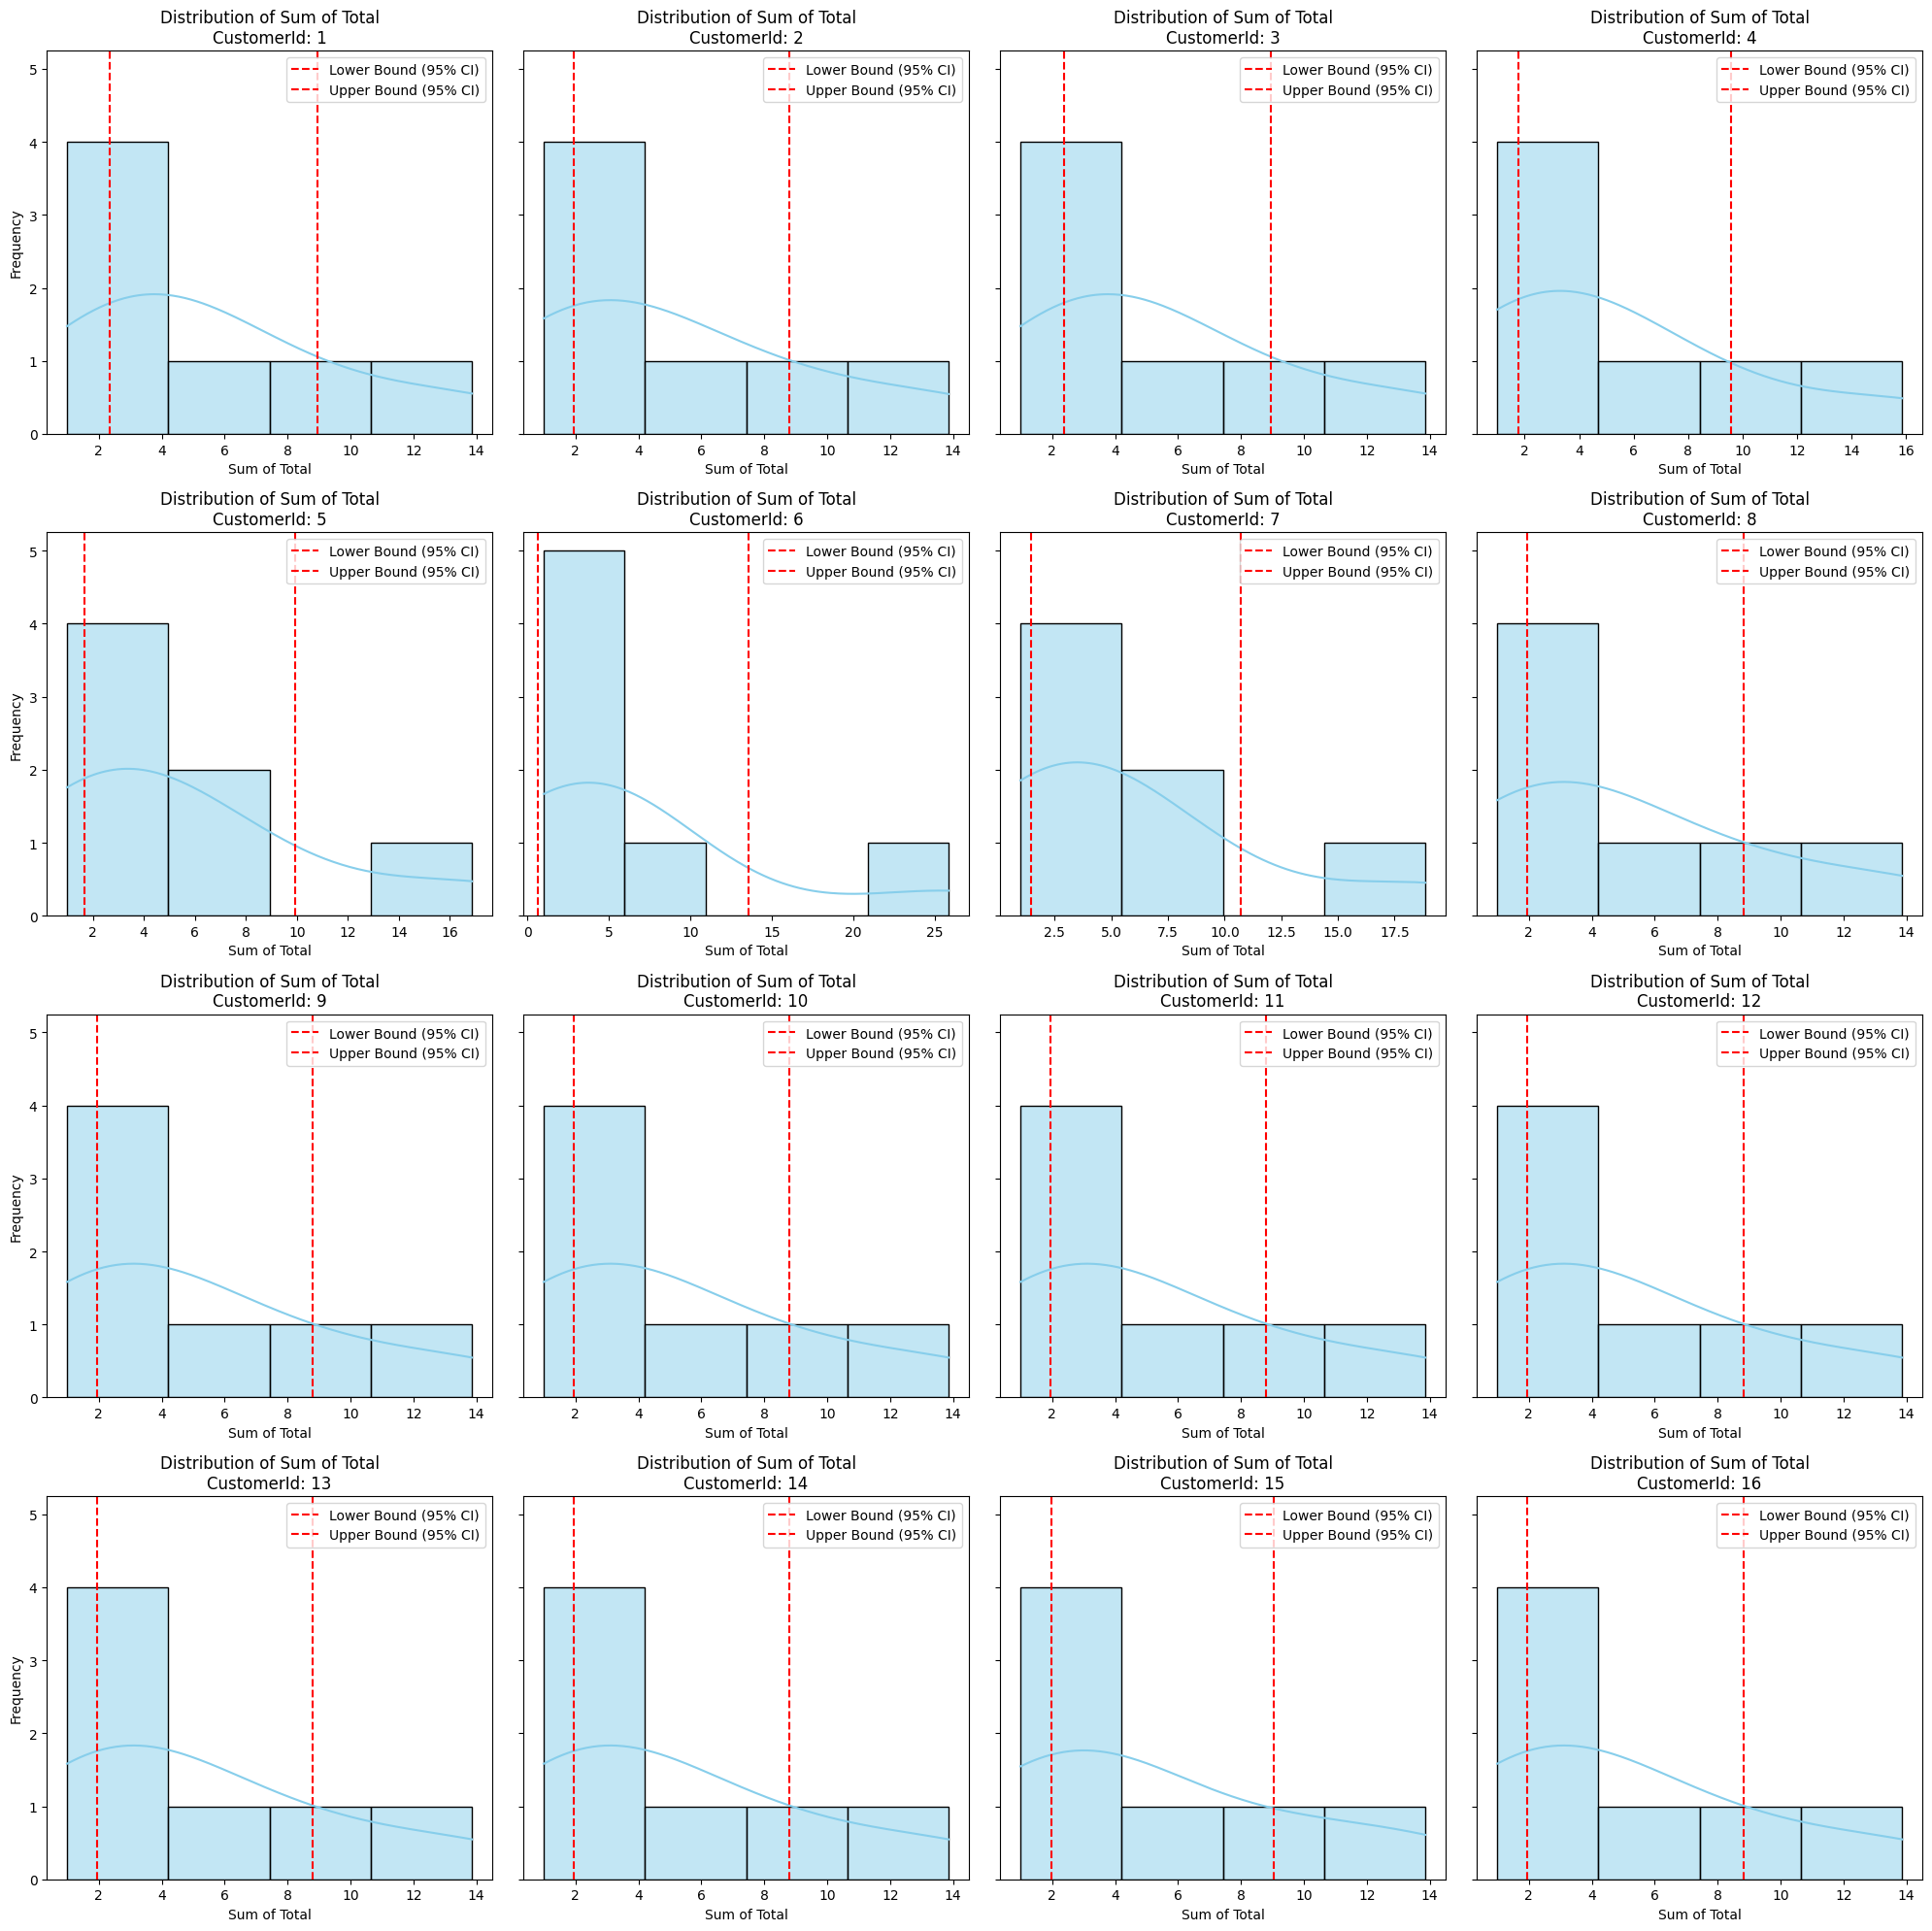

    CustomerId      Mean  CI Lower Bound  CI Upper Bound
0            1  5.660000        2.361657        8.958343
1            2  5.374286        1.938112        8.810459
2            3  5.660000        2.361657        8.958343
3            4  5.660000        1.758026        9.561974
4            5  5.802857        1.659229        9.946485
5            6  7.088571        0.629188       13.547954
6            7  6.088571        1.448687       10.728456
7            8  5.374286        1.938112        8.810459
8            9  5.374286        1.938112        8.810459
9           10  5.374286        1.938112        8.810459
10          11  5.374286        1.938112        8.810459
11          12  5.374286        1.938112        8.810459
12          13  5.374286        1.938112        8.810459
13          14  5.374286        1.938112        8.810459
14          15  5.517143        1.977021        9.057265
15          16  5.374286        1.938112        8.810459


In [17]:


invoice_invoiceLine = pd.merge(d.invoice, d.invoiceline, on='InvoiceId')
grouped_invAndinvl = invoice_invoiceLine.groupby(['CustomerId', 'InvoiceId']).agg(SumOfTotal=('Total', 'mean')).reset_index()

confidence_level = 0.95
z = stats.norm.ppf(1 - (1 - confidence_level) / 2)  # critical value for 95% confidence

results = []

# Number of customers
num_customers = grouped_invAndinvl['CustomerId'].nunique()
rows = 4
cols = 4
total_plots = min(rows * cols, num_customers)  # Total number of plots

# Create a figure with a 4x4 grid of subplots
fig, axes = plt.subplots(rows, cols, figsize=(20, 20), sharey=True)
axes = axes.flatten()  # Flatten the 2D array of axes for easier iteration

# Iterate over each customer and create a subplot
for ax, customer in zip(axes, grouped_invAndinvl['CustomerId'].unique()):
    customer_data = grouped_invAndinvl[grouped_invAndinvl['CustomerId'] == customer]['SumOfTotal']

    sample_mean = np.mean(customer_data)
    sample_std = np.std(customer_data, ddof=1)  # sample standard deviation
    n = len(customer_data)

    standard_error = sample_std / np.sqrt(n)

    lower_bound = sample_mean - z * standard_error
    upper_bound = sample_mean + z * standard_error

    results.append({
        'CustomerId': customer,
        'Mean': sample_mean,
        'CI Lower Bound': lower_bound,
        'CI Upper Bound': upper_bound
    })

    # Plotting histogram with confidence interval
    sns.histplot(customer_data, kde=True, color='skyblue', ax=ax)
    ax.axvline(x=lower_bound, color='red', linestyle='--', label='Lower Bound (95% CI)')
    ax.axvline(x=upper_bound, color='red', linestyle='--', label='Upper Bound (95% CI)')
    ax.set_title(f'Distribution of Sum of Total\nCustomerId: {customer}')
    ax.set_xlabel('Sum of Total')
    ax.set_ylabel('Frequency')
    ax.legend()

# Remove empty subplots if any
for i in range(total_plots, rows * cols):
    fig.delaxes(axes[i])

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

# Create a DataFrame to display the results
confidence_intervals = pd.DataFrame(results)
print(confidence_intervals)